In [2]:
import numpy as np
import torch
import argparse
import sys
import pickle
import pandas as pd
from lifelines import CoxPHFitter
import torchtuples as tt
import yaml 
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import uuid
import warnings

from coxkan import CoxKAN
from coxkan.datasets import gbsg, metabric, support, nwtco, flchain
from coxkan.utils import FastCoxLoss, count_parameters, bootstrap_metric, set_seed, SYMBOLIC_LIB

In [3]:
###############
### Load data
###############

exp_name = 'nwtco'
SEED = set_seed(42)
output_dir = Path('checkpoints') / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

# load dataset
dataset = nwtco
df_train, df_test = dataset.load(split=True)
dataset_name, duration_col, event_col, covariates = dataset.metadata()
assert dataset_name == exp_name

results = {'CoxKAN': {}, 'DeepSurv': {}}

Done.


In [4]:
### Loading configs

with open(f'configs/coxkan/{exp_name}.yml', 'r') as f:
    config = yaml.safe_load(f)

with open(output_dir / 'config.yml', 'w') as f:
    yaml.dump(config, f)
    
with open(f'configs/mlp/{exp_name}.yml', 'r') as f:
    mlp_config = yaml.safe_load(f)

### Init CoxKAN
ckan = CoxKAN(seed=SEED, **config['init_params'])
coxkan_params = count_parameters(ckan)

# for the simple datasets, we first pre-process and register the data with the CoxKAN object
if 'TCGA' not in exp_name:
    df_train, df_test = ckan.process_data(df_train, df_test, duration_col, event_col, normalization='standard')

# if early stopping, split the training data into train and validation sets
if config['train_params']['early_stopping'] or (mlp_config['early_stopping']):
    train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train[event_col])


In [5]:
################
###  CoxPH
################
try:
    run_coxph = True
    cph = CoxPHFitter()
    cph.fit(df_train, duration_col=duration_col, event_col=event_col)
    def cph_cindex(df):
        return cph.score(df, scoring_method='concordance_index')
    cindex_train = bootstrap_metric(cph_cindex, df_train, N=100)['formatted']
    cindex_test = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
    coxph_str = f'CoxPH - train: {cindex_train}, test: {cindex_test}'; print(coxph_str)
    with open(output_dir / 'cindex.txt', 'w') as f:
        f.write(coxph_str + '\n')
    results['CoxPH'] = {'train': cindex_train, 'test': cindex_test, 'summary': cph.summary}
except Exception as e:
    run_coxph = False
    print('CoxPH failed:', e)

CoxPH - train: 0.713773 (0.713, 0.719), test: 0.698347 (0.693, 0.703)


DeepSurv - train: 0.722460 (0.718, 0.724), test: 0.698300 (0.692, 0.703)


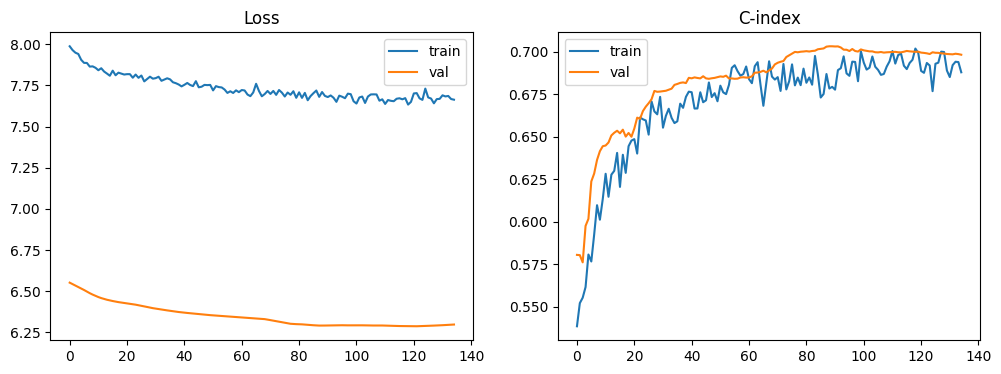

In [6]:
################
###  DeepSurv
################

mlp = tt.practical.MLPVanilla(
    in_features=len(covariates), out_features=1, output_bias=False, **mlp_config['init_params']
)
optimizer = tt.optim.Adam(**mlp_config['optimizer_params'])
deepsurv = tt.Model(mlp, loss=FastCoxLoss, optimizer=optimizer)
deepsurv_params = count_parameters(mlp)

# Convert to PyTorch tensors
X_test = torch.tensor(df_test[covariates].values).double()
y_test = torch.tensor(df_test[[duration_col, event_col]].values).double()

def mlp_cindex(df):
    lph = deepsurv.predict(torch.tensor(df[covariates].values).double())
    return concordance_index(df[duration_col], -lph, df[event_col])

def mlp_cindex_metric_fn(lph, labels):
    return concordance_index(labels[:, 0].detach().numpy(), -lph.detach().numpy(), labels[:, 1].detach().numpy())

# Training
if mlp_config['early_stopping']:
    X_val = torch.tensor(val[covariates].values).double()
    y_val = torch.tensor(val[[duration_col, event_col]].values).double()
    X_train = torch.tensor(train[covariates].values).double()
    y_train = torch.tensor(train[[duration_col, event_col]].values).double()
    log = deepsurv.fit(
        X_train, y_train, batch_size=len(X_train), val_data=(X_val, y_val), epochs=mlp_config['epochs'], verbose=False,
        metrics={'cindex': mlp_cindex_metric_fn}, callbacks=[tt.callbacks.EarlyStopping(patience=20)]
    )
else:
    X_train = torch.tensor(df_train[covariates].values).double()
    y_train = torch.tensor(df_train[[duration_col, event_col]].values).double()
    log = deepsurv.fit(
        X_train, y_train, batch_size=len(X_train), val_data=(X_test, y_test), epochs=mlp_config['epochs'], verbose=False,
        metrics={'cindex': mlp_cindex_metric_fn}
    )
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(log.to_pandas()['train_loss'], label='train'); ax[0].plot(log.to_pandas()['val_loss'], label='val')
ax[1].plot(log.to_pandas()['train_cindex'], label='train'); ax[1].plot(log.to_pandas()['val_cindex'], label='val')

# put a vertical line at the best epoch
if mlp_config['early_stopping']:
    best_epoch = log.to_pandas().val_cindex.idxmax()
    ax[0].axvline(best_epoch, color='k', linestyle='--', label='best model')
    ax[1].axvline(best_epoch, color='k', linestyle='--', label='best model')

ax[0].legend(); ax[0].set_title('Loss'); ax[1].legend(); ax[1].set_title('C-index')
fig.savefig(output_dir / 'mlp_training.png')

cindex_train = bootstrap_metric(mlp_cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(mlp_cindex, df_test, N=100)['formatted']

deepsurv_str = f'DeepSurv - train: {cindex_train}, test: {cindex_test}'; print(deepsurv_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(deepsurv_str + '\n')
results['DeepSurv'] = {'train': cindex_train, 'test': cindex_test, 'n_params': deepsurv_params}


train loss: 2.73e+00 | val loss: 2.48e+00: 100%|██████████████████| 147/147 [00:10<00:00, 13.72it/s]


Saved model to checkpoints/nwtco/model.pt
CoxKAN - train: 0.728822 (0.725, 0.730), test: 0.719829 (0.714, 0.725)
Results saved to checkpoints/nwtco/results.pkl


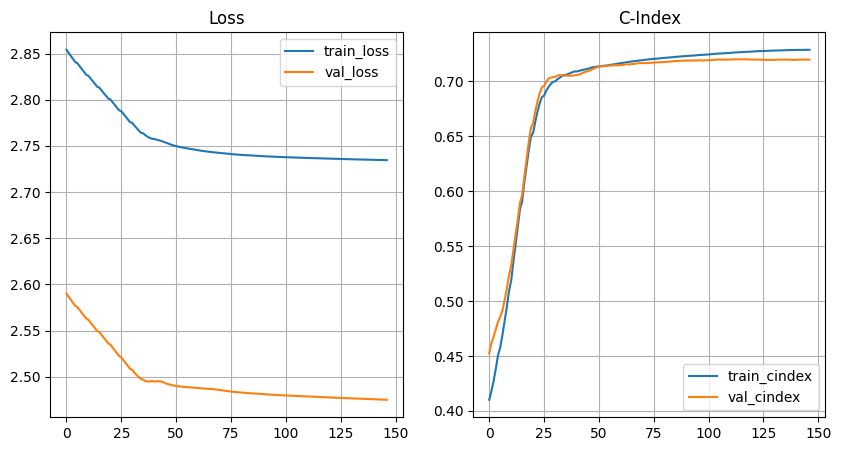

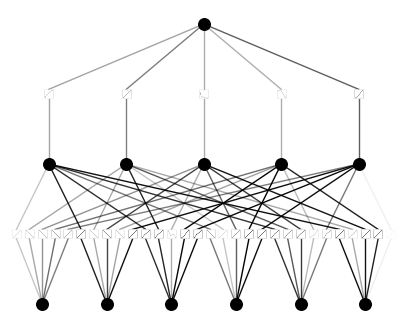

In [7]:
from copy import deepcopy

##############
### CoxKAN
##############

### Training
if config['train_params']['early_stopping']:
    # config['train_params']['steps'] = 500 # with early stopping we are free to choose high number of steps
    log = ckan.train(train, val, duration_col, event_col, **config['train_params'])
else:
    log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])

_ = ckan.predict(df_test)
ckan.save_ckpt(output_dir / 'model.pt')
fig = log.plot()
fig.savefig(output_dir / 'coxkan_training.png')

cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
cindex_val = bootstrap_metric(ckan.cindex, val, N=100)['formatted'] if config['train_params']['early_stopping'] else None
cindex_test = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pre_str = f'CoxKAN - train: {cindex_train}, test: {cindex_test}'; print(ckan_pre_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(ckan_pre_str + '\n')
results['CoxKAN']['Pre'] = {'train': cindex_train, 'test': cindex_test, 'val': cindex_val, 'n_params': coxkan_params}

fig = ckan.plot(beta=10)
fig.savefig(output_dir / 'coxkan_pre.png')

# save results
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)
    print('Results saved to', output_dir / 'results.pkl')

In [8]:
# ckan = CoxKAN(seed=SEED, **config['init_params'])
# ckan.load_ckpt(output_dir / 'model.pt')
# _ = ckan.predict(df_test)

In [9]:
### Pruning

# If early stopping was used, we have a validation set to select the best pruning threshold
if config['train_params']['early_stopping']:
    pruning_thresholds = np.linspace(0, 0.05, 20)
    pruning_thresholds[0] = config['prune_threshold']
    cindices = []
    for threshold in pruning_thresholds:
        ckan_ = CoxKAN(seed=SEED, **config['init_params'])
        ckan_.load_ckpt(output_dir / 'model.pt', verbose=False)
        _ = ckan_.predict(df_test)
        
        prunable = True
        for l in range(ckan_.depth):
            if not (ckan_.acts_scale[l] > threshold).any():
                prunable = False
                break
        if not prunable:
            if threshold == config['prune_threshold']: continue
            else: break
            
        ckan_ = ckan_.prune_nodes(threshold)

        if 0 in ckan_.width: prunable = False
        if not prunable:
            if threshold == config['prune_threshold']: continue
            else: break

        _ = ckan_.predict(df_test)
        ckan_.prune_edges(threshold, verbose=False)
        cindices.append(ckan_.cindex(val))
        print(f'Pruning threshold: {threshold:.2f}, C-Index (Val): {cindices[-1]:.6f}')
    best_threshold = pruning_thresholds[np.argmax(cindices)]
    if np.max(cindices) < 0.51: best_threshold = 0
else:
    best_threshold = config['prune_threshold']
print(f'Best pruning threshold: {best_threshold}')

Best pruning threshold: 0.02299885020284457


In [10]:
results['prune_threshold'] = best_threshold
_ = ckan.predict(df_test)
ckan = ckan.prune_nodes(best_threshold)
_ = ckan.predict(df_test)
ckan.prune_edges(best_threshold, verbose=True)
_ = ckan.predict(df_test)

Pruned activation (0,0,0)
Pruned activation (0,5,4)


CoxKAN (pruned) - train: 0.729260 (0.727, 0.732), test: 0.720708 (0.708, 0.718)


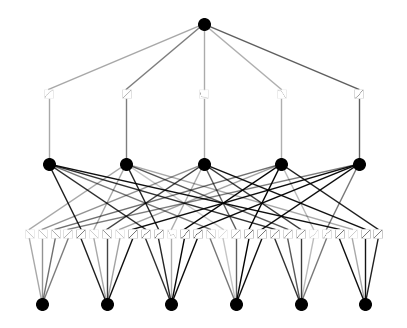

In [11]:
fig = ckan.plot(beta=10)
fig.savefig(output_dir / 'coxkan_pruned.png')
cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
if config['train_params']['early_stopping']: cindex_pruned_val = ckan.cindex(val)
else: cindex_pruned_val = None
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pru_str = f'CoxKAN (pruned) - train: {cindex_train}, test: {cindex_pruned}'; print(ckan_pru_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(ckan_pru_str + '\n')
results['CoxKAN']['Pruned'] = {'train': cindex_train, 'test': cindex_pruned, 'val': cindex_pruned_val}


In [12]:
### Symbolic Fitting

# Initial symbolic fitting (categorical covariates and linear activations)
ckan.predict(pd.concat([df_train, df_test], axis=0))
for l in range(ckan.depth):
    for i in range(ckan.width[l]):
        for j in range(ckan.width[l+1]):
            if ckan.symbolic_fun[l].funs_name[j][i] != '0':
                if l == 0 and hasattr(ckan, 'categorical_covariates') and ckan.covariates[i] in ckan.categorical_covariates:
                    ckan.fix_symbolic(l,i,j,'categorical')
                else:
                    # try linear fit (accept if R2 > 0.95)
                    _, _, r2 = ckan.suggest_symbolic(l,i,j,lib=['x'], verbose=False)
                    if r2 > 0.95:
                        ckan.fix_symbolic(l,i,j,'x',verbose=False)
                        print(f'Fixed ({l},{i},{j}) as linear')

ckan.cindex(df_test)

Fixed (0,4,0) as linear
Fixed (0,4,1) as linear
Fixed (0,4,2) as linear
Fixed (0,4,3) as linear
Fixed (0,4,4) as linear
Fixed (1,0,0) as linear
Fixed (1,1,0) as linear
Fixed (1,4,0) as linear


0.7220521489132316

### Symbolic Fitting

Here you can either call `auto_symbolic`, or you can examine the activations and choose suitable functions. I just called `auto_symbolic` for convenience.

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,0,3) since already symbolic
skipping (0,0,4) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (0,1,3) since already symbolic
skipping (0,1,4) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,2,1) since already symbolic
skipping (0,2,2) since already symbolic
skipping (0,2,3) since already symbolic
skipping (0,2,4) since already symbolic
skipping (0,3,0) since already symbolic
skipping (0,3,1) since already symbolic
skipping (0,3,2) since already symbolic
skipping (0,3,3) since already symbolic
skipping (0,3,4) since already symbolic
skipping (0,4,0) since already symbolic
skipping (0,4,1) since already symbolic
skipping (0,4,2) since already symbolic
skipping (0,4,3) since already symbolic
skipping (0,4,4) since already symbolic


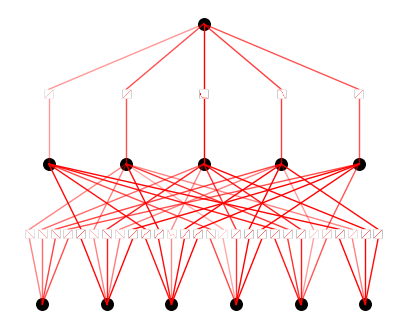

In [14]:
lib = list(SYMBOLIC_LIB.keys()).copy()

# Auto symbolic fitting for the remaining edges
if config['train_params']['early_stopping']: ckan.predict(pd.concat([val, df_test], axis=0))
else: ckan.predict(df_test)
if ckan.auto_symbolic(min_r2=0, lib=lib, verbose=True):
    cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
    formula = ckan.symbolic_formula(floating_digit=4)[0][0]
    fig = ckan.plot(beta=15)
    fig.savefig(output_dir / 'coxkan_symbolic.png', dpi=600)
else:
    # If symbolic fitting fails, set cindex to nan
    cindex_symbolic = np.nan
    formula = None
    print('Symbolic fitting failed.')

try:
    if config['train_params']['early_stopping']: cindex_symbolic_val = ckan.cindex(val)
    if cindex_symbolic_val/cindex_pruned_val < 0.9:
        warnings.warn("Symbolic fitting caused a reduction in the validation set C-Index by more than 10%, consider re-running the script with a different seed.", UserWarning)
except: pass 

In [15]:
### Save results
try: cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
except: cindex_train = np.nan

ckan_sym_str = f'CoxKAN (symbolic) - train: {cindex_train}, test: {cindex_symbolic}'; print(ckan_sym_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(ckan_sym_str + '\n')

CoxKAN (symbolic) - train: 0.723729 (0.719, 0.725), test: 0.722225 (0.715, 0.725)


In [16]:
if 'sigmoid' in str(formula): formula = str(formula)

results['CoxKAN']['Symbolic'] = {'train': cindex_train, 'test': cindex_symbolic, 'formula': formula}
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

# save c-index results to txt file too
with open(output_dir / 'cindex.txt', 'w') as f:
    if run_coxph: f.write(coxph_str + '\n')
    f.write(deepsurv_str + '\n')
    f.write(ckan_pre_str + '\n')
    f.write(ckan_pru_str + '\n')
    f.write(ckan_sym_str + '\n')

### Interpretability of NWTCO

There are currently 2 interaction terms. Lets look at them.

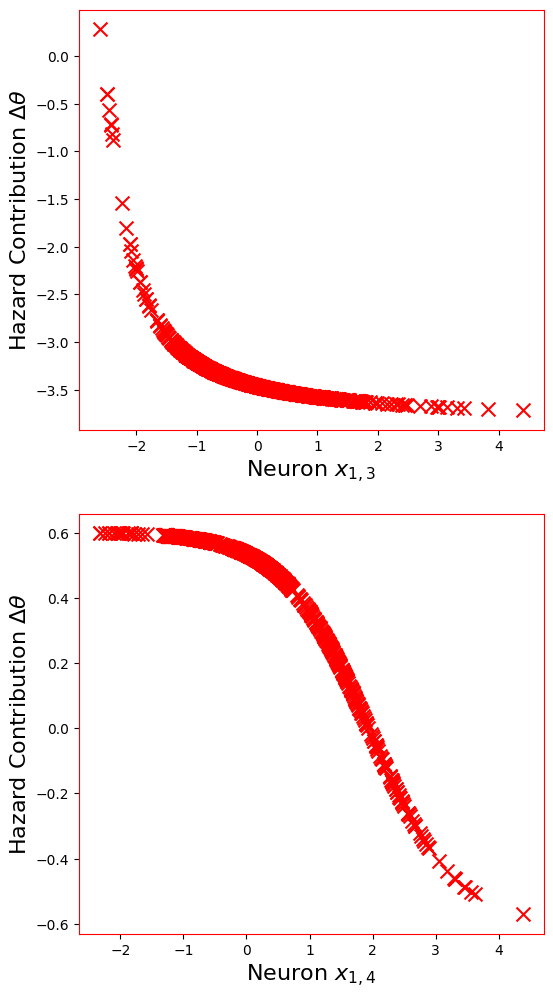

In [17]:
ckan.predict(df_test)

def set_red(ax):
    # Set the colors for the axes, labels, and tick marks
    ax.spines['bottom'].set_color('red')
    ax.spines['top'].set_color('red') 
    ax.spines['right'].set_color('red')
    ax.spines['left'].set_color('red')
    
    # ax.xaxis.label.set_color('red')
    # ax.yaxis.label.set_color('red')
    
    # ax.tick_params(axis='x', colors='red')
    # ax.tick_params(axis='y', colors='red')
    
    ax.title.set_color('red')

fig, ax = plt.subplots(2, 1, figsize=(6, 12))

l, i, j = 1, 2, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

x_lim_min = min(inputs)-0.5
x_lim_max = max(inputs)+0.5

y_lim_min = min(outputs)-0.5
y_lim_max = max(outputs)+0.5

ax[0].scatter(inputs, outputs, marker='x', s=100, c='red')
ax[0].set_xlabel(r'Neuron $x_{1,3}$', fontsize=16)
ax[0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=16)
set_red(ax[0])

l, i, j = 1, 3, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

ax[1].scatter(inputs, outputs, marker='x', s=100, c='red')
ax[1].set_xlabel(r'Neuron $x_{1,4}$', fontsize=16)
ax[1].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=16)
set_red(ax[1])

fig.savefig(output_dir / 'coxkan_nonlinears.png')

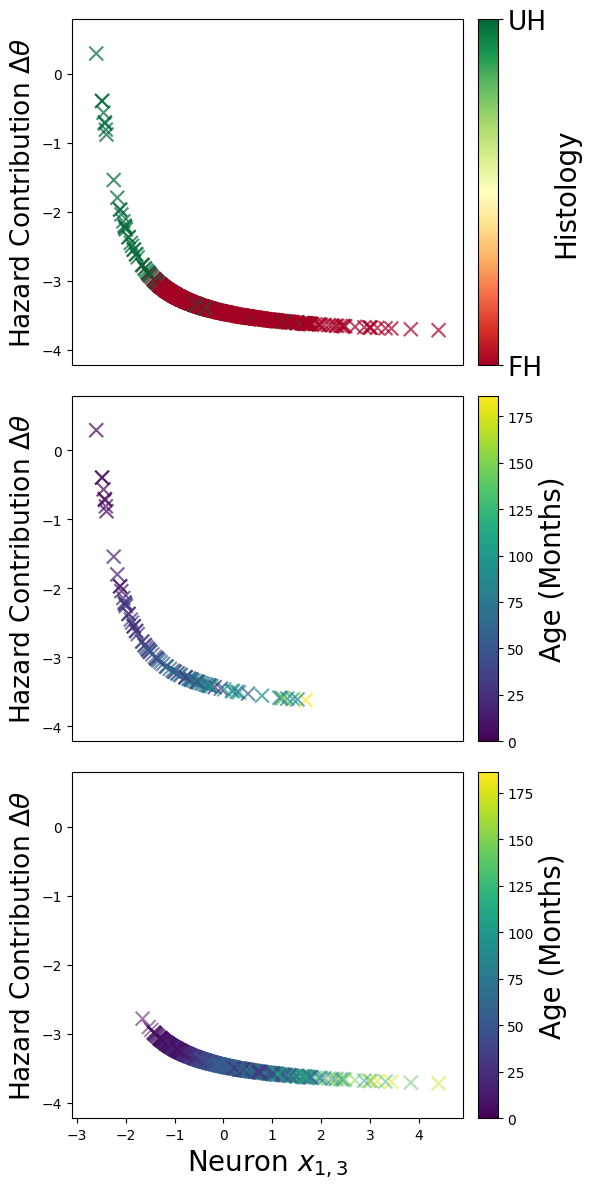

In [18]:
from matplotlib.gridspec import GridSpec

_, df_test_unnorm = nwtco.load(split=True)

# Create a figure with GridSpec
fig = plt.figure(figsize=(6, 12))
gs = GridSpec(3, 2, width_ratios=[1, 0.05], height_ratios=[1, 1, 1], figure=fig)

# Create subplots
ax0 = fig.add_subplot(gs[0])
cax0 = fig.add_subplot(gs[1])

ax1 = fig.add_subplot(gs[2])
cax1 = fig.add_subplot(gs[3])

ax2 = fig.add_subplot(gs[4])
cax2 = fig.add_subplot(gs[5])

# All histologies
ckan.predict(df_test)

l, i, j = 1, 2, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

ax0.scatter(inputs, outputs, c=df_test_unnorm['histol'], cmap='RdYlGn', alpha=0.7, marker='x', s=100)
ax0.set_ylim([y_lim_min, y_lim_max])
ax0.set_xlim([x_lim_min, x_lim_max])
ax0.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=19)
ax0.set_xticks([])

# Create a colorbar for the first subplot
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=1, vmax=2))
sm._A = []
cbar = plt.colorbar(sm, cax=cax0)
cbar.set_label('Histology', fontsize=20)
cbar.set_ticks([1, 2])
cbar.set_ticklabels(['FH', 'UH'], fontsize=19)

# Unfavourable histology
df_test_subset = df_test[df_test_unnorm['histol'] == 2]
df_test_unnorm_subset = df_test_unnorm[df_test_unnorm['histol'] == 2]
ckan.predict(df_test_subset)

l, i, j = 1, 2, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

# Scatter plots
sc0 = ax1.scatter(inputs, outputs, c=df_test_unnorm_subset['age'], cmap='viridis', alpha=0.7, marker='x', s=100, label='Unfavourable Histology')
ax1.set_ylim([y_lim_min, y_lim_max])
ax1.set_xlim([x_lim_min, x_lim_max])
ax1.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=19)
ax1.set_xticks([])

# Create a colorbar for the first subplot
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=df_test_unnorm['age'].min(), vmax=df_test_unnorm['age'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax1)
cbar.set_label('Age (Months)', fontsize=20)

# Favourable Histology
df_test_subset = df_test[df_test_unnorm['histol'] == 1]
df_test_unnorm_subset = df_test_unnorm[df_test_unnorm['histol'] == 1]
ckan.predict(df_test_subset)

l, i, j = 1, 2, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

sc1 = ax2.scatter(inputs, outputs, c=df_test_unnorm_subset['age'], cmap='viridis', alpha=0.5, marker='x', s=100, label='Favourable Histology')
ax2.set_ylim([y_lim_min, y_lim_max])
ax2.set_xlim([x_lim_min, x_lim_max])
ax2.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=19)
ax2.set_xlabel(r'Neuron $x_{1,3}$', fontsize=20)

# Create a colorbar for the second subplot
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=df_test_unnorm['age'].min(), vmax=df_test_unnorm['age'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax2)
cbar.set_label('Age (Months)', fontsize=20)

plt.tight_layout()

fig.savefig(output_dir / 'coxkan_interaction.png')

Takeaway:
- For Favourable histology, the interaction term gives age less influence over the histology -> the isolation term dominates, and patient risk increases with age. 
- For Unfavourable histology, the interaction term is such that the effect of age outweighs 

We now validate this using CoxPHFitter

In [19]:
from lifelines import CoxPHFitter

df = nwtco.load(split=False)

# Favourable
df_FH = df[df['histol'] == 1]

cph = CoxPHFitter()
cph.fit(df_FH[['age', 'edrel', 'rel']], duration_col='edrel', event_col='rel')
print(cph.summary['coef'])

# Unfavourable histology and young
df_UH = df[df['histol'] == 2]

cph = CoxPHFitter()
cph.fit(df_UH[['age', 'edrel', 'rel']], duration_col='edrel', event_col='rel')
print(cph.summary['coef'])

# Unfavourable histology and young
df_UH_young = df_UH[df_UH['age'] < 20]

cph = CoxPHFitter()
cph.fit(df_UH_young[['age', 'edrel', 'rel']], duration_col='edrel', event_col='rel')
print(cph.summary['coef'])

# Just young
df_young = df[df['age'] < 20]

cph = CoxPHFitter()
cph.fit(df_young[['age', 'edrel', 'rel']], duration_col='edrel', event_col='rel')
print(cph.summary['coef'])

covariate
age    0.01255
Name: coef, dtype: float64
covariate
age   -0.006454
Name: coef, dtype: float64
covariate
age   -0.143562
Name: coef, dtype: float64
covariate
age   -0.087618
Name: coef, dtype: float64
